# Grid Search
## Set up

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Getting data
loading in preprocessed data saved as "all_projects.csv"

In [23]:
df_all = pd.read_csv("all_projects.csv")

## Creating training and testing datasets
For the training the columns "project" and "project_url" should not have an effect on sustainability. The columns "init" and "end" should not have an effect either. The running time of the project is present in STA-1 (which is calculated from "init" and "end").

The data is divided into X and y:
- X: the factors that we want to use to predict the value of y
- y: the factor we want to predict (sustainable or unstainable)

Furthermore the data is split into "train" and "test":
- "train": is to be used for training the model
- "test": is used to measure its accuracy after training.

In [24]:
df_all = df_all.drop(columns=["project","init","end","project_url"])

X = df_all.drop(columns=["status"])
y = df_all["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
print("Number of data rows in train:", X_train.shape[0])
print("Number of data rows in test:", X_test.shape[0])

Number of data rows in train: 177
Number of data rows in test: 60


## Grid Search of models
Grid search is used to find the best parameters for a model, by testing how well they score on the dataset. They can be scored on multiple parameters, but in our case we have choosen to find the best parameters based on their ROC-AUC score.

We have choosen to test the same models as the paper before us did.

In [26]:
y_pred = np.zeros_like(y_test)

In [27]:
# Set random seed for reproducibility
random_seed = np.random.seed(42)

In [28]:
classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_seed),
    'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Support Vector Machine': SVC(random_state=random_seed, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_seed)
}

param_grids = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 5]},
    'Support Vector Machine': {'C': [0.1, 1, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [29]:
best_models = {}
for name, classifier in classifiers.items():
    print(f"\n{80*'-'}\n{f'Training {name}':^80}\n{80*'-'}")
    grid_search = GridSearchCV(classifier, param_grid=param_grids[name], scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Training ROC-AUC: {grid_search.best_score_:.2f}")


--------------------------------------------------------------------------------
                              Training Naive Bayes                              
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.80

--------------------------------------------------------------------------------
                          Training Logistic Regression                          
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.001}
Training ROC-AUC: 0.89

--------------------------------------------------------------------------------
                             Training Decision Tree                             
--------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Training ROC-AUC: 0.94

--------------------------------------------------

In [30]:
print("\nTest Set Evaluation:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {accuracy:.2f}")


Test Set Evaluation:
Naive Bayes: Accuracy = 0.55
Logistic Regression: Accuracy = 0.77
Decision Tree: Accuracy = 0.83
Random Forest: Accuracy = 0.88
Support Vector Machine: Accuracy = 0.80
Gradient Boosting: Accuracy = 0.82


GaussianNB does not have feature importances.
LogisticRegression does not have feature importances.


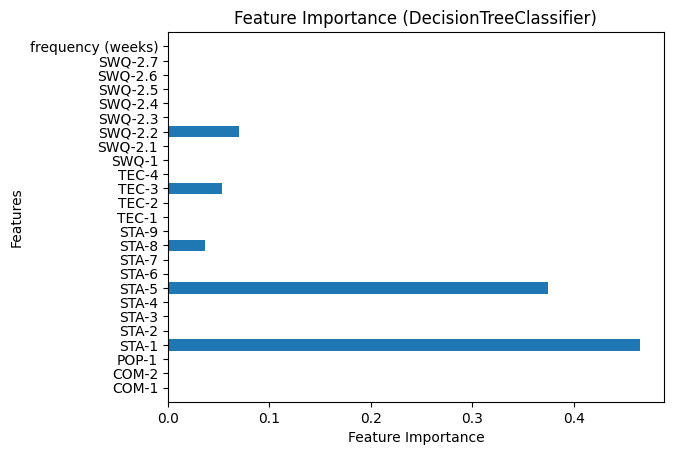

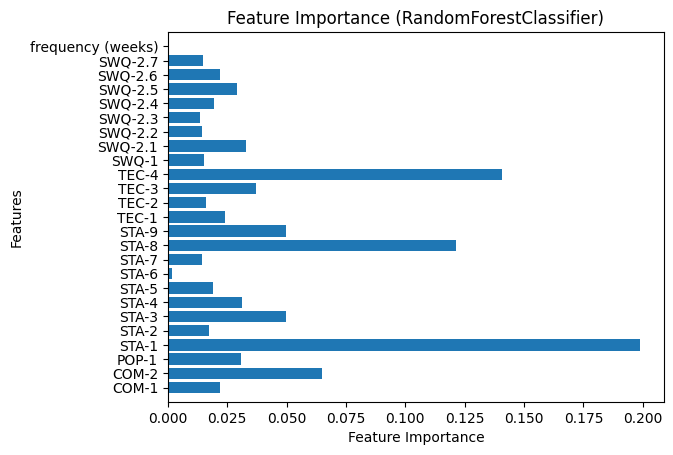

SVC does not have feature importances.


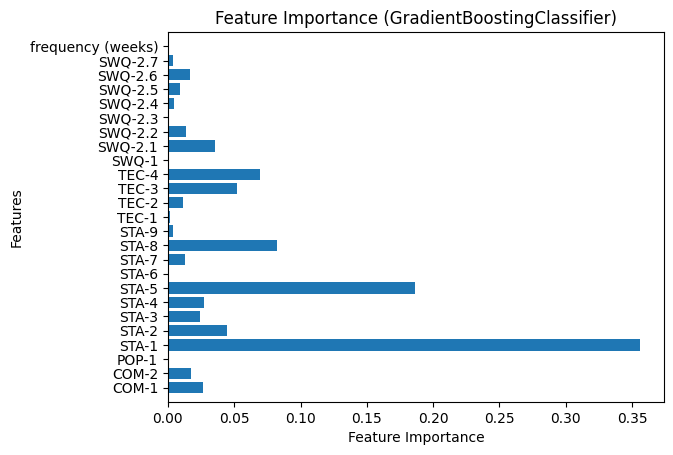

In [31]:
def plot_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        # For models that have feature_importances_
        n_features = len(feature_names)
        plt.barh(np.arange(n_features), model.feature_importances_, align='center')
        plt.yticks(np.arange(n_features), feature_names)
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.ylim(-1, n_features)
        plt.title(f"Feature Importance ({model.__class__.__name__})")
        plt.show()
    else:
        print(f"{model.__class__.__name__} does not have feature importances.")

for name, model in best_models.items():
    plot_feature_importances(model, X.columns.tolist())


In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

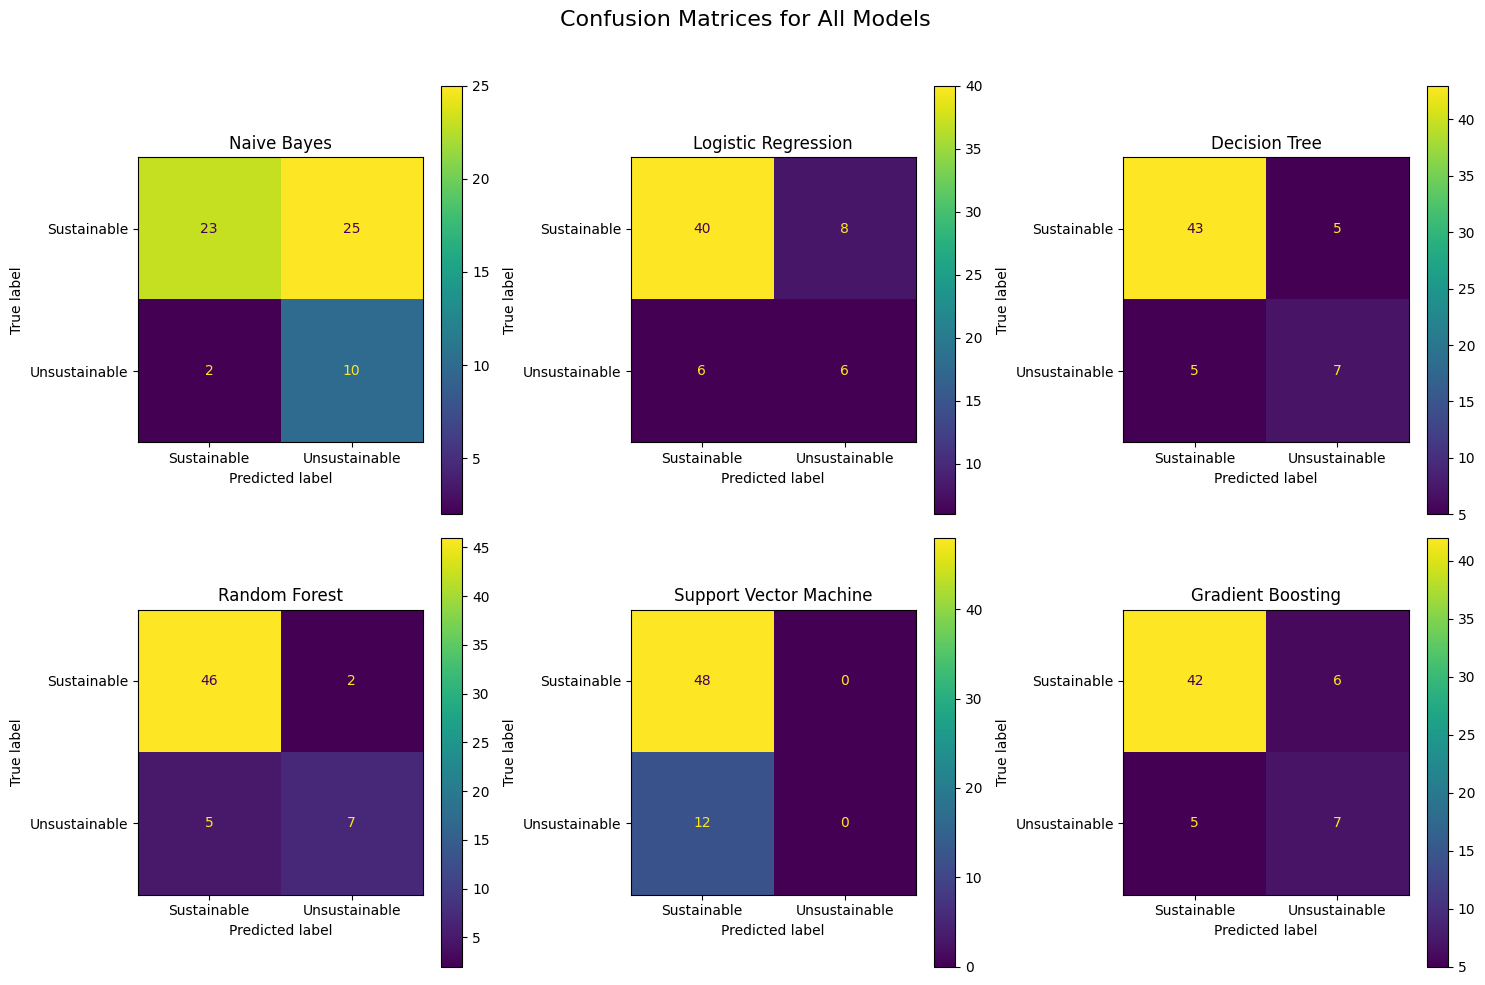

In [33]:
class_labels = ["Sustainable", "Unsustainable"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
fig.suptitle("Confusion Matrices for All Models", fontsize=16)

axes = axes.flatten()

for idx, (name, model) in enumerate(best_models.items()):
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=class_labels, ax=axes[idx]
    )
    axes[idx].set_title(f"{name}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Oversampling 
Helps balance the dataset by duplicating or generating new minority class samples.

In [34]:
classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_seed),
    'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Support Vector Machine': SVC(random_state=random_seed, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_seed)
}

param_grids = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 5]},
    'Support Vector Machine': {'C': [0.1, 1, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [36]:
sampling_names = ["No Sampling", "SMOTE", "Random Oversampling", "ADASYN"]
results = {sampling_name: {} for sampling_name in sampling_names}

def compute_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='graduated')
    recall = recall_score(y_test, y_pred, pos_label='graduated')
    f1 = f1_score(y_test, y_pred, pos_label='graduated')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    return accuracy, precision, recall, f1, roc_auc

def train_models(sampling_name, sampler=None):
    if sampler:
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        print(f"Original class distribution:\n{y_train.value_counts()}")
        print(f"\n Resampled class distribution:\n{y_resampled.value_counts()}")
    else:
        X_resampled, y_resampled = X_train, y_train

    
    best_models_sampled = {}
    for name, classifier in classifiers.items():
        print(f"\n{80*'-'}\n{f'Training {name} ({sampling_name})':^80}\n{80*'-'}")
        grid_search = GridSearchCV(classifier, param_grid=param_grids[name], scoring='roc_auc', cv=5)
        grid_search.fit(X_resampled, y_resampled)

        best_model = grid_search.best_estimator_
        best_models_sampled[name] = best_model

        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Training ROC-AUC: {grid_search.best_score_:.2f}")

    # Metrics
    for name, model in best_models_sampled.items():
        accuracy, precision, recall, f1, roc_auc = compute_metrics(model, X_test, y_test)
        
        # Store the results
        results[sampling_name][name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }

    # Confusion Matrix
    print(f"\nGenerating Confusion Matrices ({sampling_name})...")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Confusion Matrices ({sampling_name})", fontsize=16)

    axes = axes.flatten()
    class_labels = ["graduated", "retired"]

    for idx, (name, model) in enumerate(best_models_sampled.items()):
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_labels, ax=axes[idx])
        axes[idx].set_title(f"{name}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## SMOTE (Synthetic Minority Over-sampling Technique)
Generates synthetic samples by interpolating between existing minority class instances.

Original class distribution:
status
graduated    142
retired       35
Name: count, dtype: int64

 Resampled class distribution:
status
graduated    142
retired      142
Name: count, dtype: int64

--------------------------------------------------------------------------------
                          Training Naive Bayes (SMOTE)                          
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.86

--------------------------------------------------------------------------------
                      Training Logistic Regression (SMOTE)                      
--------------------------------------------------------------------------------


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Hyperparameters: {'C': 1}
Training ROC-AUC: 0.92

--------------------------------------------------------------------------------
                         Training Decision Tree (SMOTE)                         
--------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 20}
Training ROC-AUC: 0.96

--------------------------------------------------------------------------------
                         Training Random Forest (SMOTE)                         
--------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Training ROC-AUC: 0.99

--------------------------------------------------------------------------------
                    Training Support Vector Machine (SMOTE)                     
---------------------------------------------------

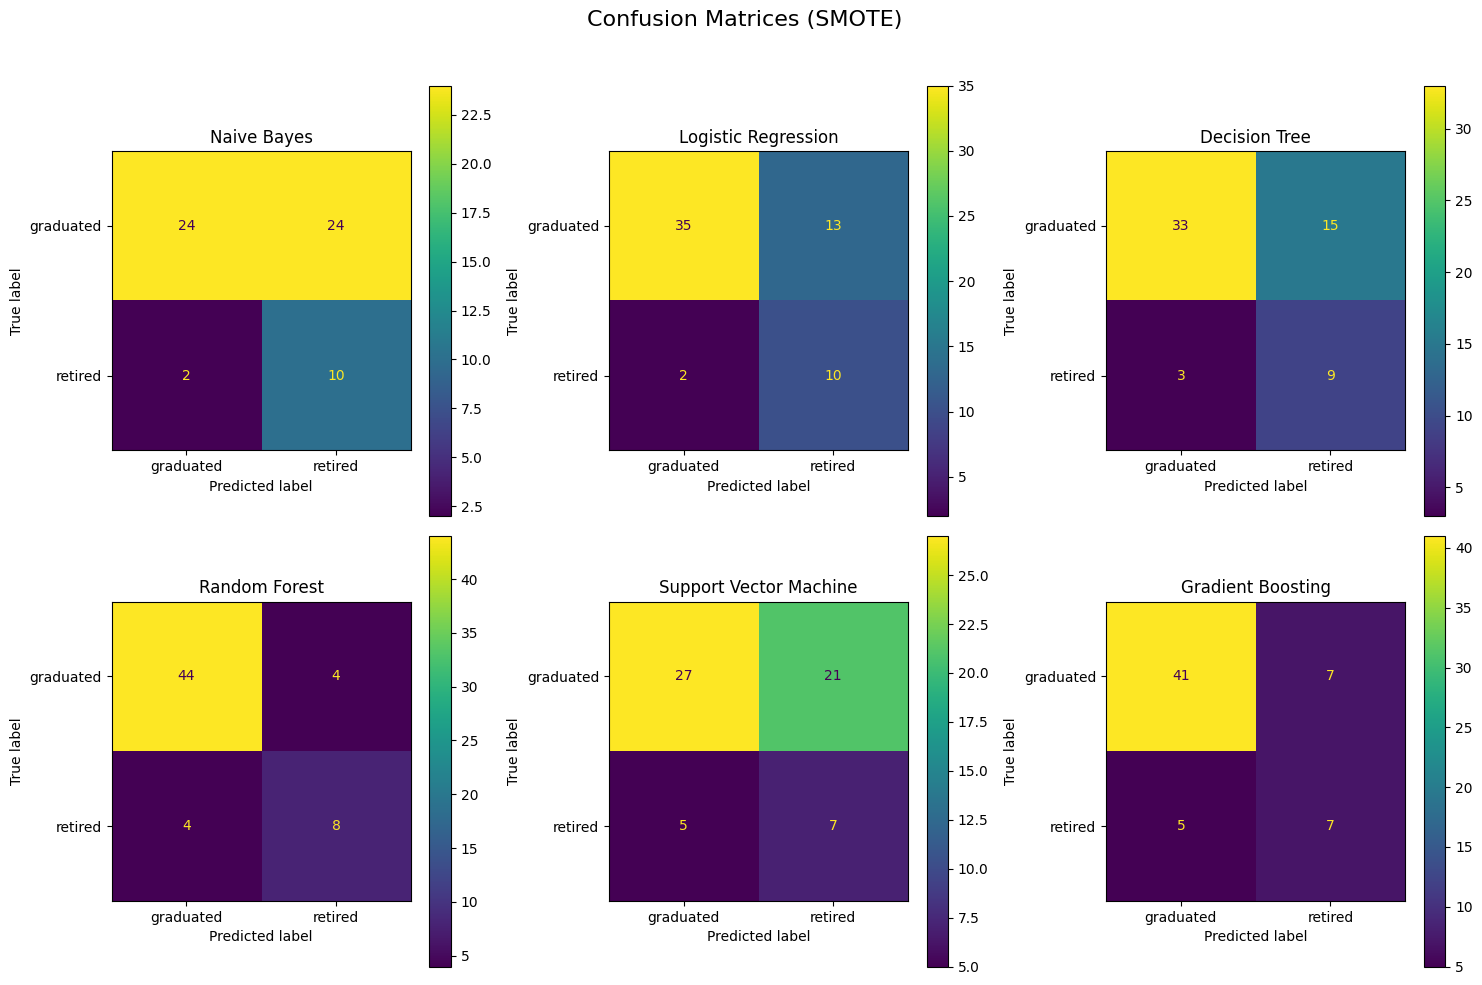

In [37]:
from imblearn.over_sampling import SMOTE

train_models("SMOTE", SMOTE(random_state=random_seed))

## ADASYN (Adaptive Synthetic Sampling)
Similar to SMOTE but generates samples more aggressively in regions where the minority class is sparse.

Original class distribution:
status
graduated    142
retired       35
Name: count, dtype: int64

 Resampled class distribution:
status
graduated    142
retired      140
Name: count, dtype: int64

--------------------------------------------------------------------------------
                         Training Naive Bayes (ADASYN)                          
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.87

--------------------------------------------------------------------------------
                     Training Logistic Regression (ADASYN)                      
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.1}
Training ROC-AUC: 0.90

--------------------------------------------------------------------------------
                        Training Decision Tree (ADASYN)                         
--------------------------------------------------

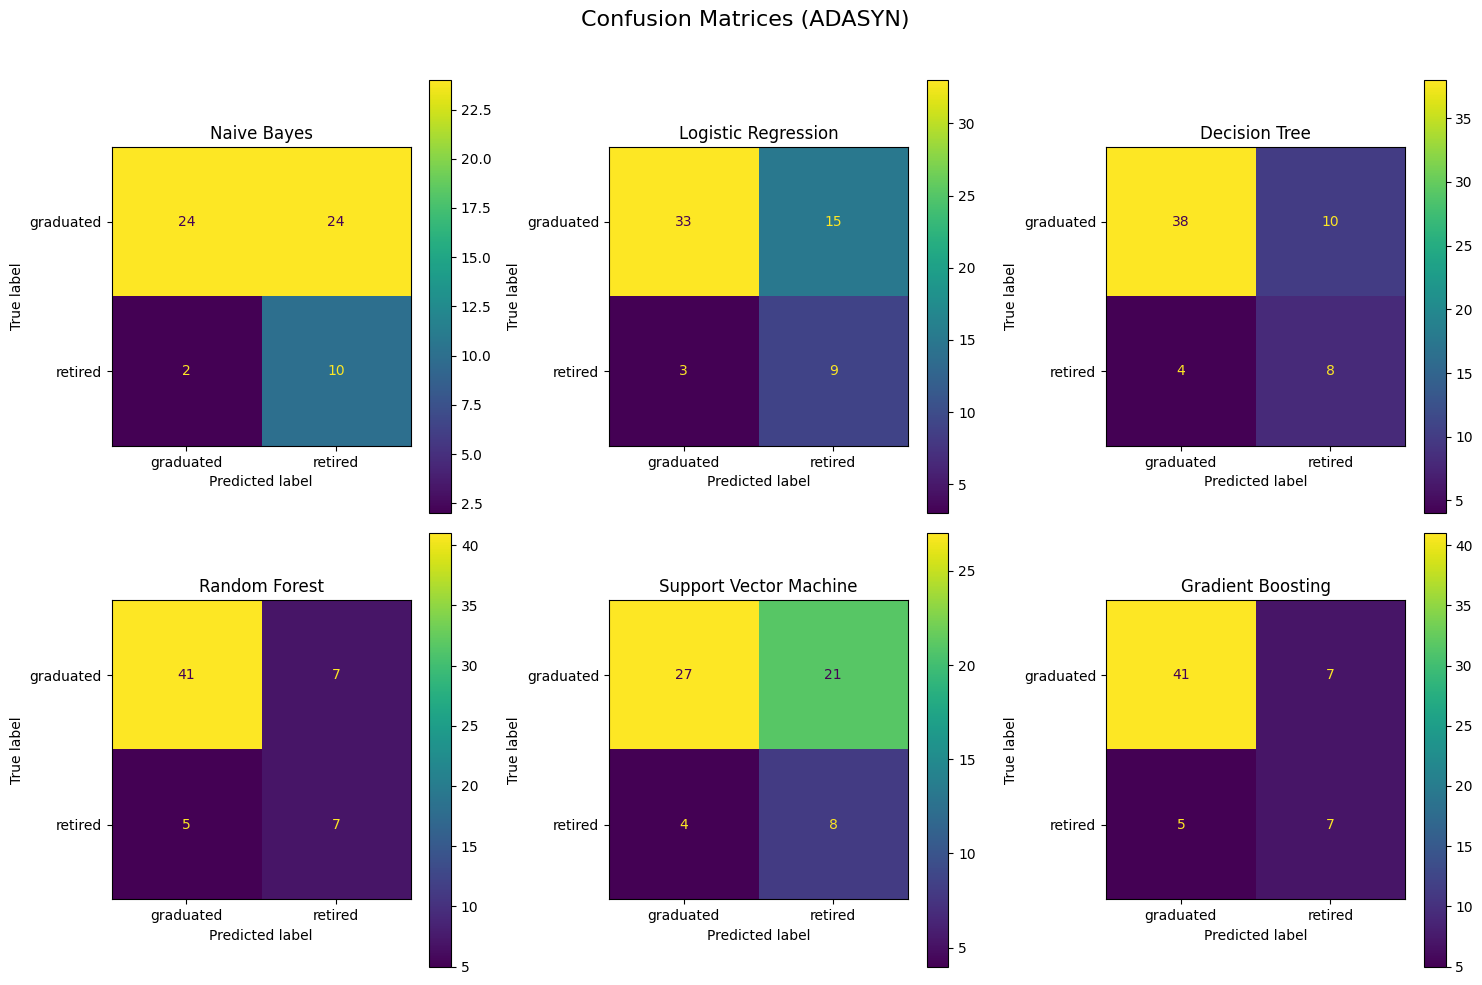

In [38]:
from imblearn.over_sampling import ADASYN

train_models("ADASYN", ADASYN(random_state=random_seed))

## Random Oversampling
Simply duplicates existing minority class samples.

Original class distribution:
status
graduated    142
retired       35
Name: count, dtype: int64

 Resampled class distribution:
status
graduated    142
retired      142
Name: count, dtype: int64

--------------------------------------------------------------------------------
                   Training Naive Bayes (Random Oversampling)                   
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.85

--------------------------------------------------------------------------------
               Training Logistic Regression (Random Oversampling)               
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.1}
Training ROC-AUC: 0.91

--------------------------------------------------------------------------------
                  Training Decision Tree (Random Oversampling)                  
--------------------------------------------------

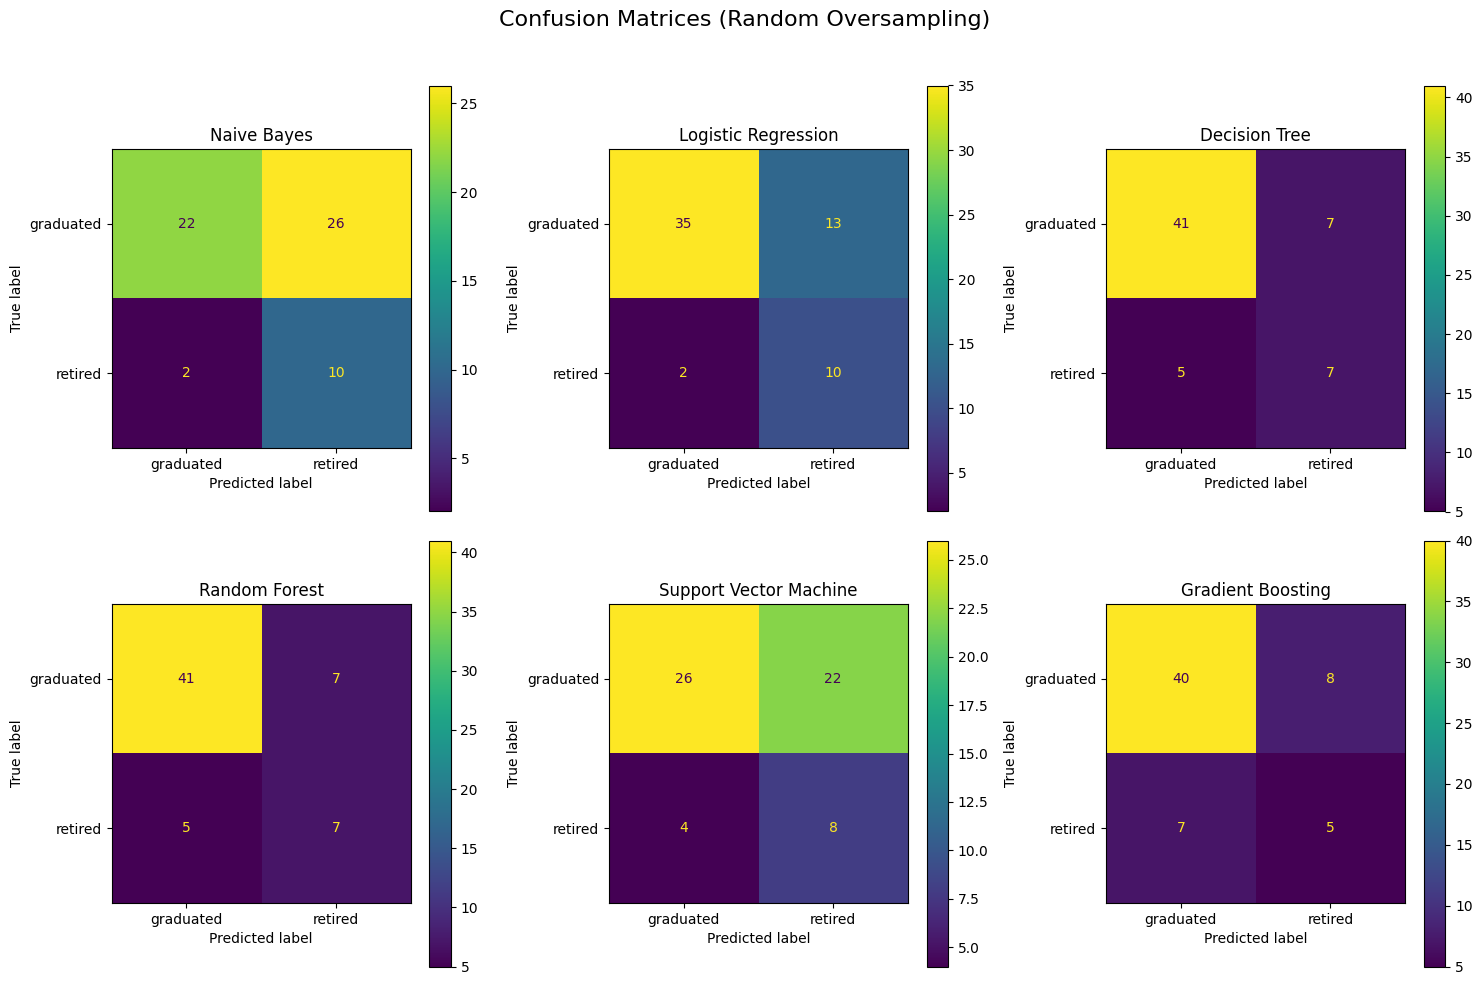

In [39]:
from imblearn.over_sampling import RandomOverSampler

train_models("Random Oversampling", RandomOverSampler(random_state=random_seed))

## Comparison of Results
Run "no sampling" for comparison purposes:


--------------------------------------------------------------------------------
                       Training Naive Bayes (No Sampling)                       
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.80

--------------------------------------------------------------------------------
                   Training Logistic Regression (No Sampling)                   
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.001}
Training ROC-AUC: 0.89

--------------------------------------------------------------------------------
                      Training Decision Tree (No Sampling)                      
--------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Training ROC-AUC: 0.94

------------------------------------------------

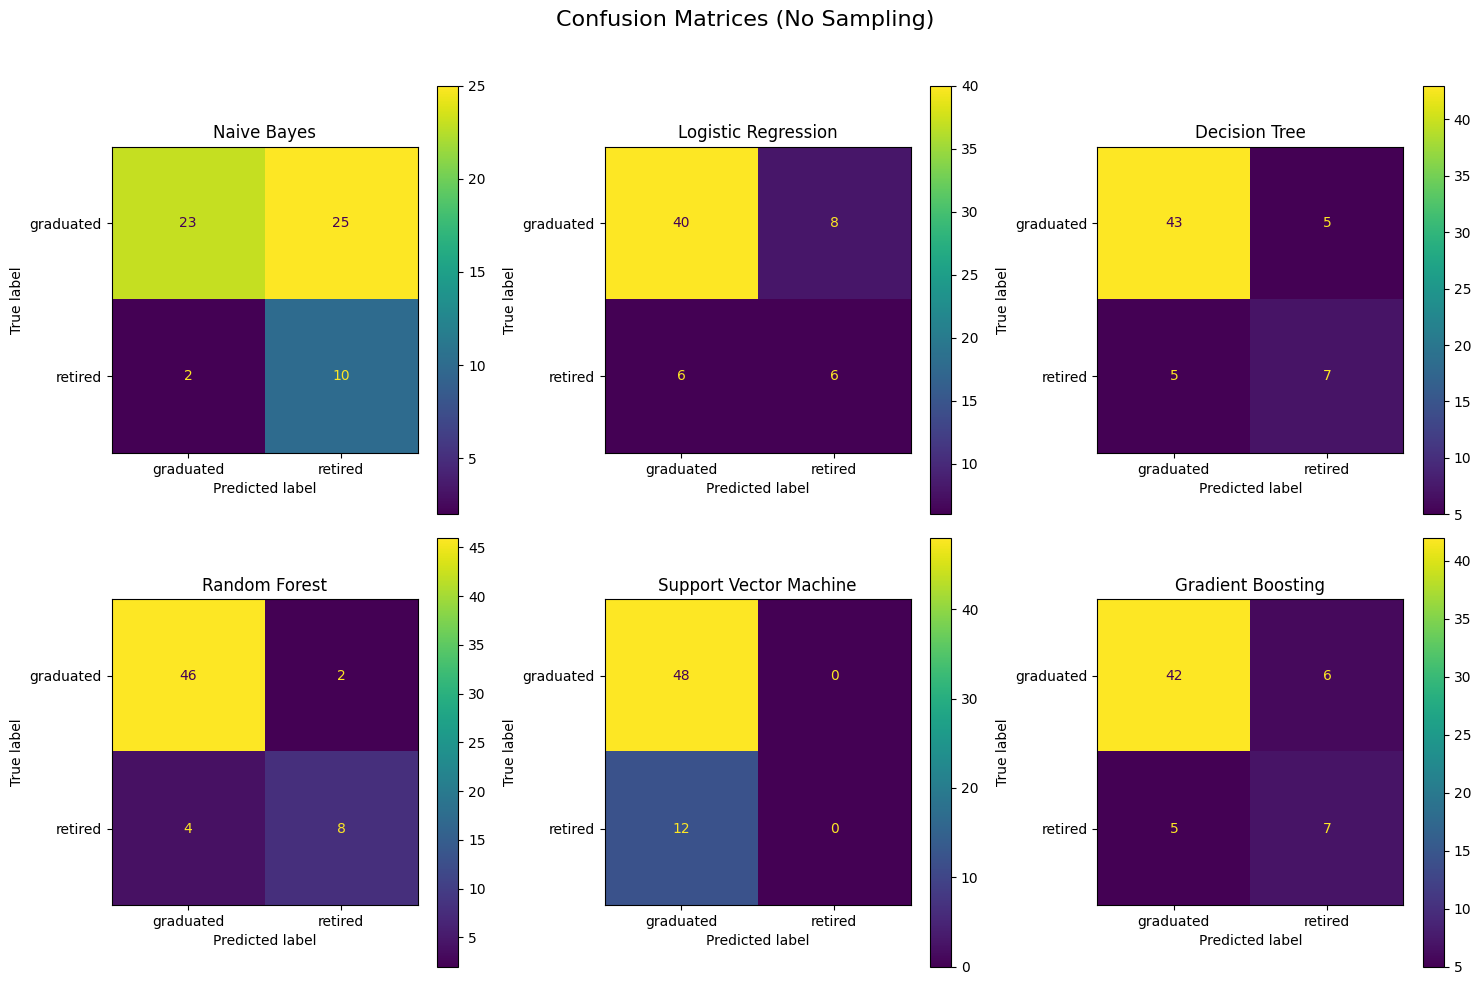

In [40]:
train_models("No Sampling")

In [41]:
print("\nComparison of Results (Metrics for Different Sampling Techniques):")
for sampling_name, models in results.items():
    print(f"\n{sampling_name}:")
    for model_name, metrics in models.items():
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")


Comparison of Results (Metrics for Different Sampling Techniques):

No Sampling:

Naive Bayes:
  Accuracy: 0.55
  Precision: 0.92
  Recall: 0.48
  F1-Score: 0.63
  ROC-AUC: 0.84

Logistic Regression:
  Accuracy: 0.77
  Precision: 0.87
  Recall: 0.83
  F1-Score: 0.85
  ROC-AUC: 0.78

Decision Tree:
  Accuracy: 0.83
  Precision: 0.90
  Recall: 0.90
  F1-Score: 0.90
  ROC-AUC: 0.81

Random Forest:
  Accuracy: 0.90
  Precision: 0.92
  Recall: 0.96
  F1-Score: 0.94
  ROC-AUC: 0.87

Support Vector Machine:
  Accuracy: 0.80
  Precision: 0.80
  Recall: 1.00
  F1-Score: 0.89
  ROC-AUC: 0.42

Gradient Boosting:
  Accuracy: 0.82
  Precision: 0.89
  Recall: 0.88
  F1-Score: 0.88
  ROC-AUC: 0.85

SMOTE:

Naive Bayes:
  Accuracy: 0.57
  Precision: 0.92
  Recall: 0.50
  F1-Score: 0.65
  ROC-AUC: 0.85

Logistic Regression:
  Accuracy: 0.75
  Precision: 0.95
  Recall: 0.73
  F1-Score: 0.82
  ROC-AUC: 0.76

Decision Tree:
  Accuracy: 0.70
  Precision: 0.92
  Recall: 0.69
  F1-Score: 0.79
  ROC-AUC: 0.7

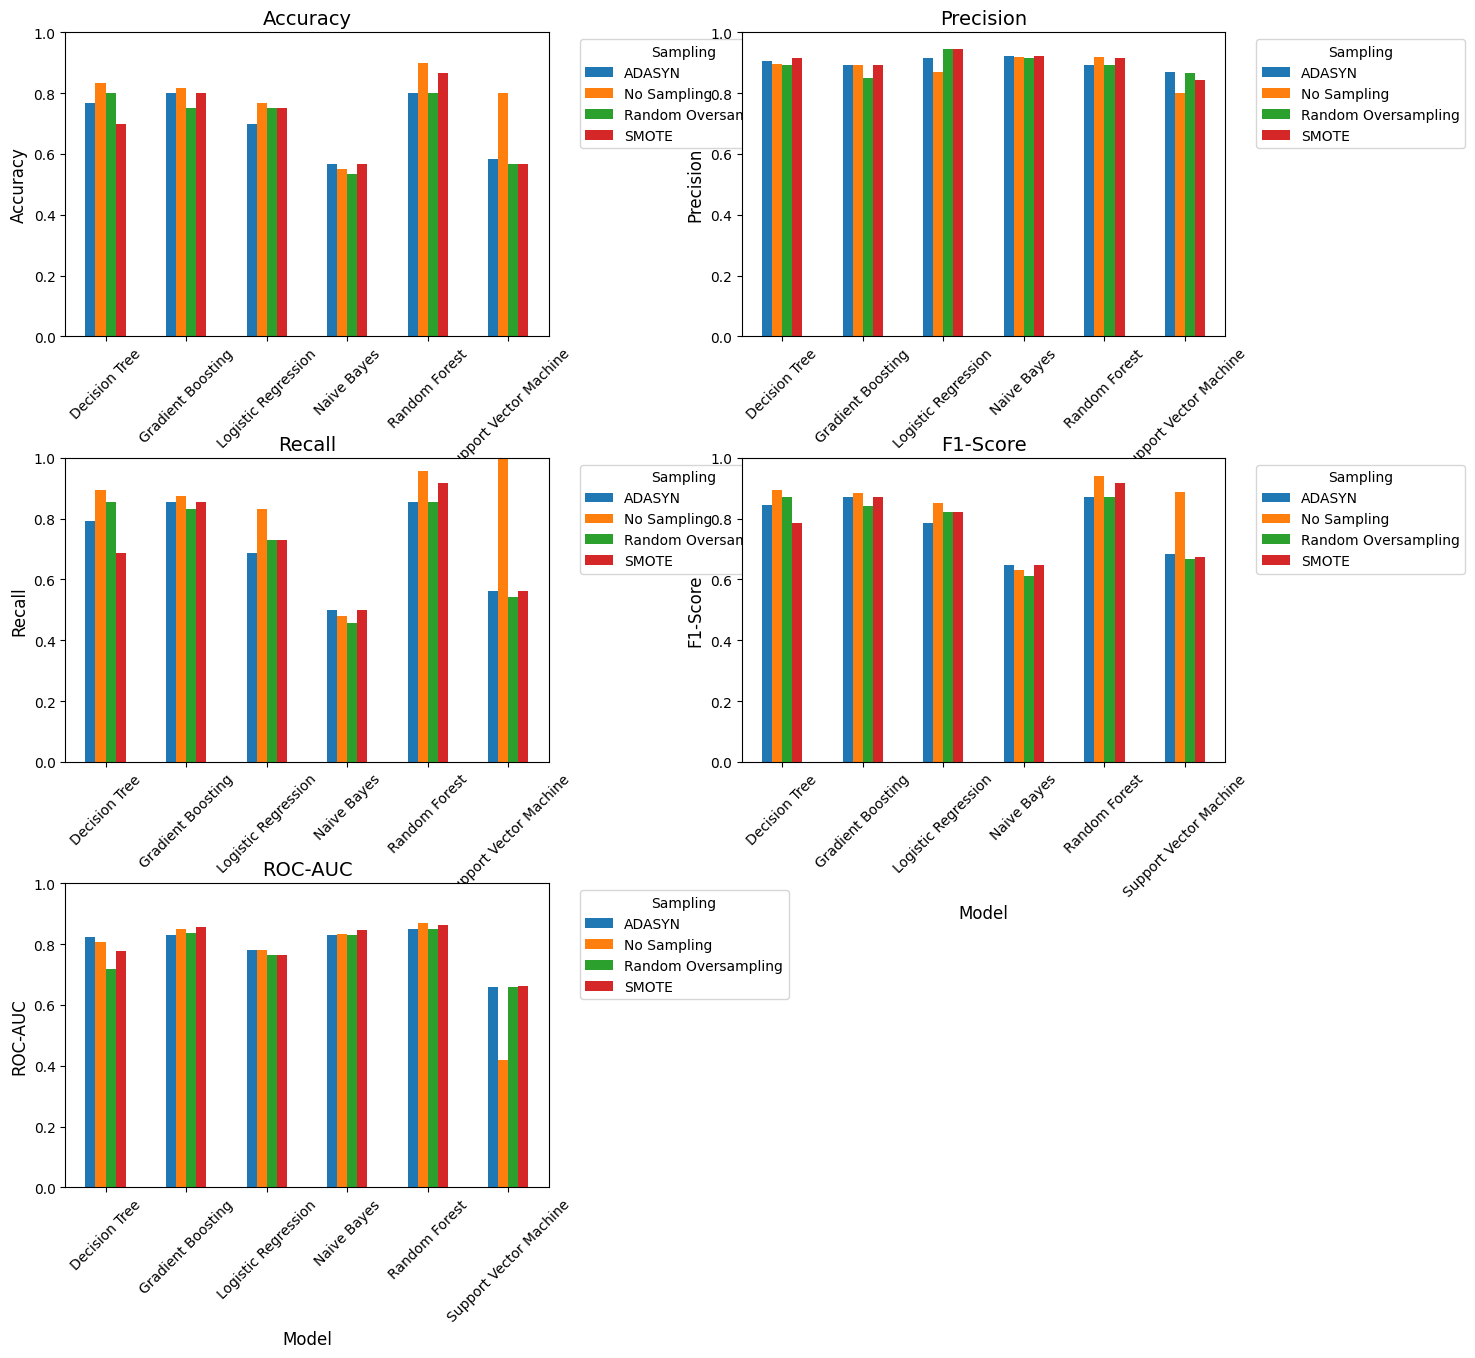

In [45]:
comparison_data = []

for sampling_name, models in results.items():
    for model_name, metrics in models.items():
        for metric, value in metrics.items():
            comparison_data.append({
                'Sampling': sampling_name,
                'Model': model_name,
                'Metric': metric,
                'Value': value
            })

comparison_df = pd.DataFrame(comparison_data)

unique_metrics = comparison_df['Metric'].unique()
num_metrics = len(unique_metrics)

ncols = 2
nrows = math.ceil(num_metrics / ncols) 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5 * nrows))  
axes = axes.flatten()

for i, metric in enumerate(unique_metrics):
    ax = axes[i]
    metric_df = comparison_df[comparison_df['Metric'] == metric]
    pivot_df = metric_df.pivot(index='Model', columns='Sampling', values='Value')

    pivot_df.plot(kind='bar', ax=ax, ylim=(0, 1))
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.tick_params(axis='x', rotation=45)  

    # Move legend outside plot
    ax.legend(title='Sampling', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Hide unused subplots if metrics count is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.subplots_adjust(right=0.85, hspace=0.4, wspace=0.4)
plt.show()

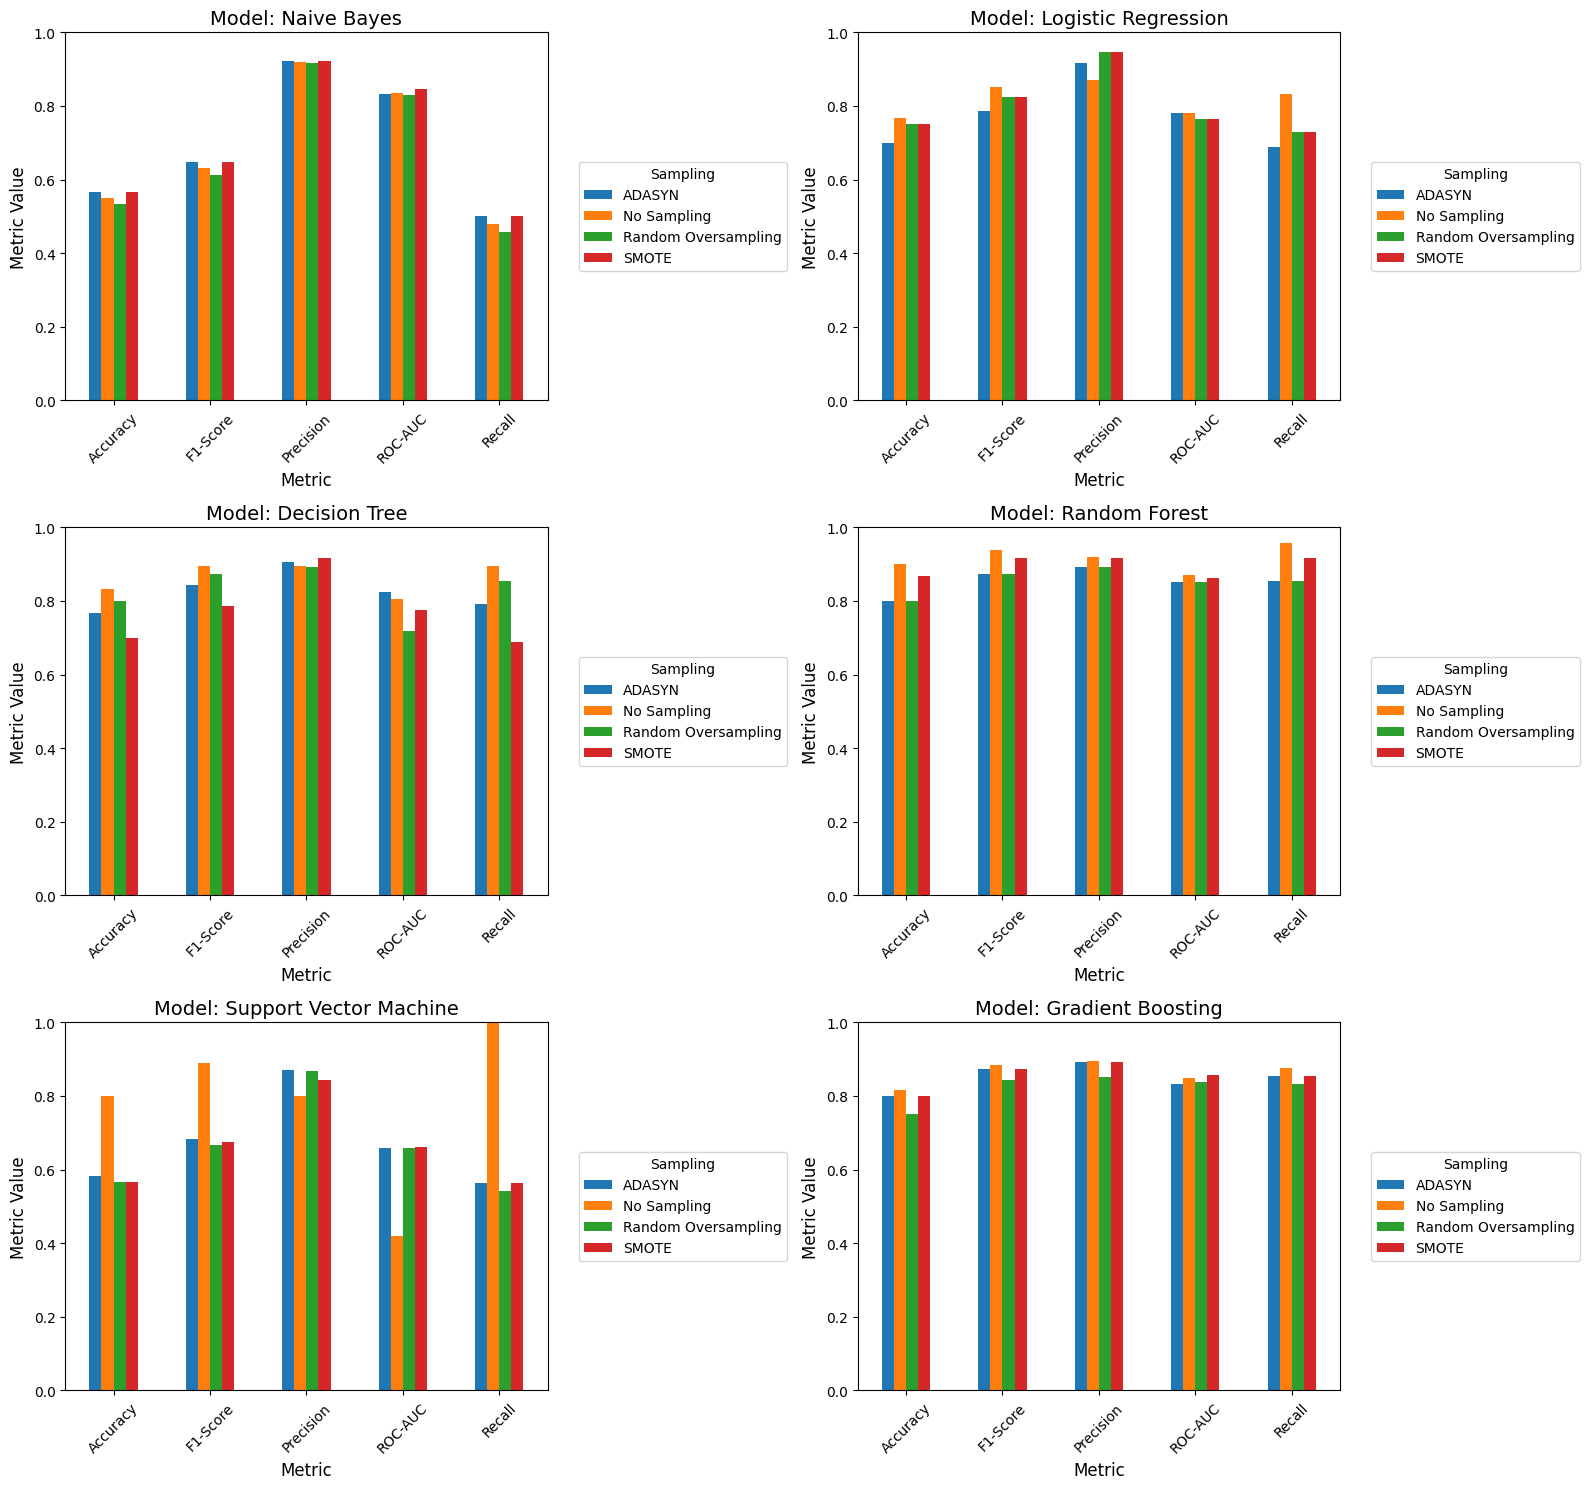

In [58]:
comparison_data = []
for sampling_name, models in results.items():
    for model_name, metrics in models.items():
        for metric, value in metrics.items():
            comparison_data.append({
                'Sampling': sampling_name,
                'Model': model_name,
                'Metric': metric,
                'Value': value
            })

comparison_df = pd.DataFrame(comparison_data)

unique_models = comparison_df['Model'].unique()
nmodels = len(unique_models)

# Set up subplots
ncols = 2
nrows = math.ceil(nmodels / ncols)  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5 * nrows))
axes = axes.flatten()

# Iterate through each model and plot performance metrics
for i, model in enumerate(unique_models):
    ax = axes[i]
    model_df = comparison_df[comparison_df['Model'] == model]
    pivot_df = model_df.pivot(index='Metric', columns='Sampling', values='Value')
    pivot_df.plot(kind='bar', ax=ax, ylim=(0, 1))
    
    ax.set_title(f"Model: {model}", fontsize=14)
    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Metric Value', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    ax.legend(title='Sampling', fontsize=10, bbox_to_anchor=(1.05, 0.5), loc='center left')

# Hide any unused subplots if models count is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(right=0.85, hspace=0.4, wspace=0.4)
plt.tight_layout()
plt.show()

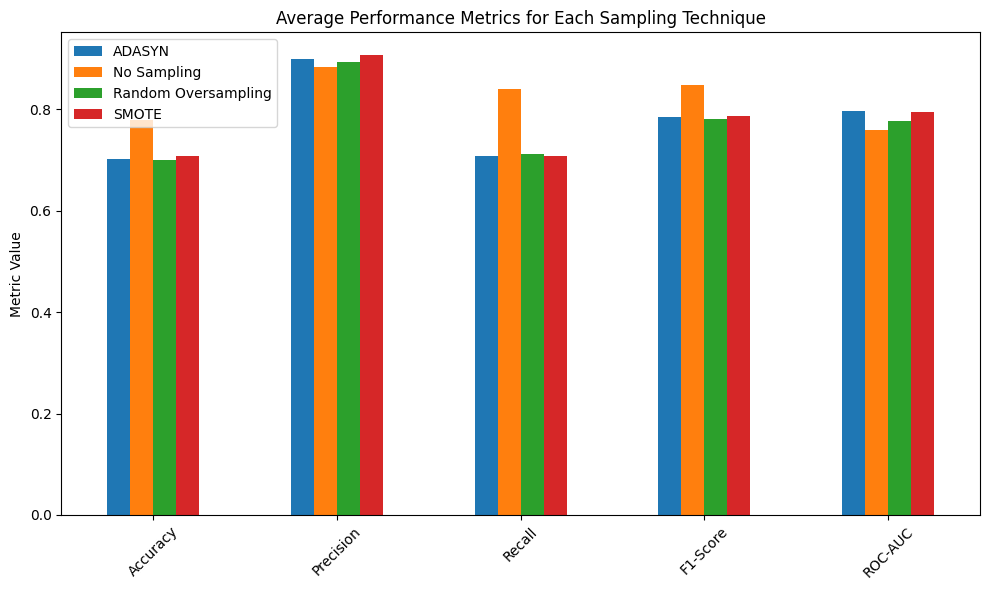

In [63]:
sampling_names = ["ADASYN","No Sampling", "Random Oversampling", "SMOTE"]
average_results = {sampling_name: {} for sampling_name in sampling_names}

for sampling_name, models in results.items():
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        average_results[sampling_name][metric] = sum(
            metrics[metric] for model_name, metrics in models.items()
        ) / len(models)

average_comparison_df = pd.DataFrame(average_results)

average_comparison_df.plot(kind='bar', figsize=(10, 6), title="Average Performance Metrics for Each Sampling Technique")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Accuracy**: Measures overall correctness (i.e., how many predictions are right).  
**High**: The model is making mostly correct predictions.  
**Low**: The model is often wrong.  

**Precision**: Measures how often positive predictions are actually correct (TP / (TP + FP)).  
**High**: Few false positives, meaning predictions are reliable.  
**Low**: Many false positives, meaning incorrect positives are common.  

**Recall**: Measures how many actual positives were correctly identified (TP / (TP + FN)).  
**High**: The model catches most real positives.  
**Low**: The model misses many positives (false negatives).  

**F1-Score**: Harmonic mean of precision and recall, balancing both metrics.  
**High**: The model is good at both precision and recall.  
**Low**: The model struggles with either false positives or false negatives.  

**ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**: Measures how well the model distinguishes between classes.  
**High (~1.0)**: The model is excellent at distinguishing positives and negatives.  
**Low (~0.5 or lower)**: The model performs poorly, close to random guessing. 

---

**1. No Sampling (Baseline)**
**Strong accuracy (0.81), high precision (0.90), and recall (0.89)** → Well-balanced model.  
**Lower ROC-AUC (0.77)** → Model might struggle with borderline cases.  

**2. SMOTE**
**Higher precision (0.93) but lower recall (0.78)** → Model is more cautious, reducing false positives but missing some real positives.  
**Accuracy (0.76) dropped** → May indicate overfitting to synthetic data.  

**3. Random Oversampling**
**Good balance between precision (0.92) and recall (0.81)** → Slightly better recall than SMOTE, leading to a strong F1-score (0.85).  
**Accuracy (0.77) is lower than baseline but still competitive** → A viable option.  
**ROC-AUC (0.79) is the best** → Suggests better distinction between classes.  

**4. ADASYN**
**Highest precision (0.94) but recall (0.79) similar to SMOTE** → Prioritizes precision over recall.  
**F1-score (0.84) and accuracy (0.77) are in line with SMOTE and Random Oversampling** → No major advantage over the other methods.  
**ROC-AUC (0.77) matches SMOTE** → No clear improvement in overall classification ability.  

---

**Conclusion & Recommendation**  
**If false positives are more costly:** **No Sampling** is the best since it has a strong balance of accuracy, precision, and recall.  
**If false negatives are more costly:** **Random Oversampling** is the best, as it improves recall (0.81) while maintaining a good F1-score (0.85) and the highest ROC-AUC (0.79).  
**SMOTE and ADASYN** don’t offer a clear advantage over Random Oversampling in this case.  